In [46]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
to_mmddyyyyHHMM = lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")
climate_data = pd.read_csv('climate_15min_int_data.csv',index_col=0,converters={'datetime':to_mmddyyyyHHMM})

<h3>Random forest while spliting the data calculates the importance or relevance of dependent variables towards the prediting variable and rates them as per their importance</h3>
<h3> We will use this feature of random forest as feature selection technique and select the most important feature for fitting models</h3>

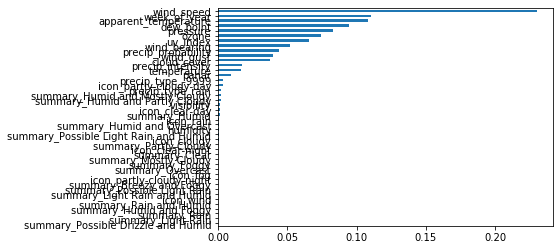

In [16]:
climate_data_shuffled=climate_data.sample(frac=1).reset_index(drop=True)
y=climate_data_shuffled['power']
X=climate_data_shuffled.drop(['power','datetime'],axis=1)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rfr=RandomForestRegressor(n_estimators=100)
rfr.fit(X,y)
import matplotlib.pyplot as plt
feat_importances = pd.Series(rfr.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

<h3>Select Most Important features from the data</h3>

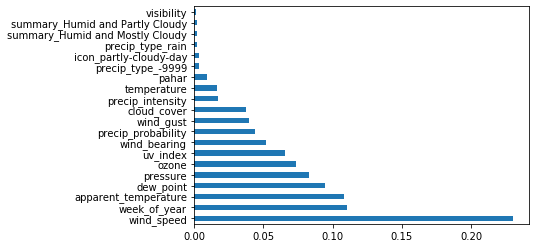

In [17]:
feat_importances.nlargest(20).plot(kind='barh')

In [18]:
climate_data_featured=climate_data_shuffled[feat_importances.sort_values(ascending=False)[:20].index.to_list()+['power','datetime']]

In [23]:
climate_data_featured.sort_values('datetime',inplace=True)
climate_data_featured.set_index('datetime',inplace=True)

C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<h3>Standard scale the data</h3>

In [24]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
X_std=ss.fit_transform(climate_data_featured)
X_std=pd.DataFrame(X_std,columns=climate_data_featured.columns,index=climate_data_featured.index)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [50]:
X_std.columns

Index(['wind_speed', 'week_of_year', 'apparent_temperature', 'dew_point',
       'pressure', 'ozone', 'uv_index', 'wind_bearing', 'precip_probability',
       'wind_gust', 'cloud_cover', 'precip_intensity', 'temperature', 'pahar',
       'precip_type_-9999', 'icon_partly-cloudy-day', 'precip_type_rain',
       'summary_Humid and Mostly Cloudy', 'summary_Humid and Partly Cloudy',
       'visibility', 'power'],
      dtype='object')

Error while writing the result file index 21 is out of bounds for axis 0 with size 21
Error while writing the result file index 22 is out of bounds for axis 0 with size 21
Error while writing the result file index 23 is out of bounds for axis 0 with size 21


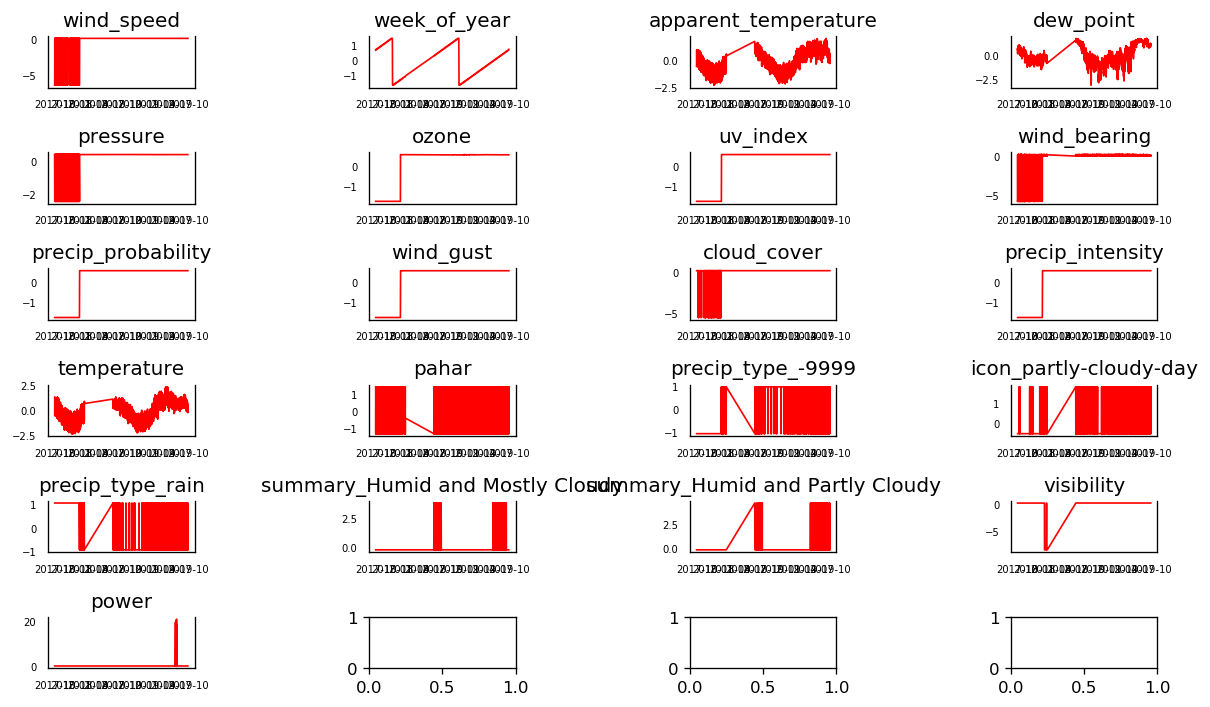

In [30]:
fig, axes = plt.subplots(nrows=6, ncols=4, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    try:
        data = X_std[X_std.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        # Decorations
        ax.set_title(X_std.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
    except Exception as e:
        print('Error while writing the result file',e)
plt.tight_layout();

<h3>A Function to do Grangers Causualty test, Null hypothesis here is to check if history values of each parameters is impacting the values of new values of all the other parameters</h3>

In [25]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

<h3>Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.</h3>

In [32]:
grangers_causation_matrix(X_std, variables = X_std.columns)    

C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\R

C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\R

C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 6
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\R

C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\

C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\R

C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)


,wind_speed_x,week_of_year_x,apparent_temperature_x,dew_point_x,pressure_x,ozone_x,uv_index_x,wind_bearing_x,precip_probability_x,wind_gust_x,...,precip_intensity_x,temperature_x,pahar_x,precip_type_-9999_x,icon_partly-cloudy-day_x,precip_type_rain_x,summary_Humid and Mostly Cloudy_x,summary_Humid and Partly Cloudy_x,visibility_x,power_x
wind_speed_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0605,0.1215,0.4393,0.5316
week_of_year_y,0.8271,1.0000,0.0492,0.0017,0.3753,0.5006,0.5050,0.8382,0.5048,0.5047,...,0.5048,0.0490,0.9952,0.9033,0.6153,0.9033,0.5246,0.7093,0.0105,0.9799
apparent_temperature_y,0.0000,0.0452,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0018,0.0000,0.0018,0.0000,0.0008,0.6668,0.0015
dew_point_y,0.9261,0.1348,0.0000,1.0000,0.0000,0.2262,0.2347,0.0008,0.2277,0.2274,...,0.2277,0.0000,0.0000,0.0001,0.0008,0.0001,0.0004,0.0572,0.5940,0.7607
pressure_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0290,0.1176
ozone_y,0.5029,0.1159,0.9800,0.0957,0.0000,1.0000,0.9317,0.4330,0.9338,0.9332,...,0.9335,0.9666,0.6996,0.9765,0.0000,0.9765,0.9996,0.9964,0.9765,0.9908
uv_index_y,0.5029,0.1174,0.8600,0.1681,0.0000,0.9616,1.0000,0.4338,0.8116,0.8465,...,0.8170,0.8527,0.9177,0.9717,0.0000,0.9717,0.9908,0.9636,0.9962,0.9950
wind_bearing_y,0.0000,0.0000,0.0000,0.0079,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0002,0.0000,0.0977,0.1656,0.3290,0.6204
precip_probability_y,0.5029,0.1177,0.9792,0.0889,0.0000,1.0000,0.9998,0.4297,1.0000,0.9999,...,0.9985,0.9554,0.6695,0.9989,0.0000,0.9989,0.9994,0.9997,0.9990,0.9934
wind_gust_y,0.5029,0.1175,0.9797,0.0910,0.0000,0.9863,0.9350,0.4305,0.9039,1.0000,...,0.9060,0.9558,0.6651,0.9985,0.0000,0.9985,0.9978,0.9976,0.9967,0.9868


<h3> Check for Co-Integration test of data</h3>

In [33]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(X_std[X_std.columns[:12]])
cointegration_test(X_std[X_std.columns[12:]])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
wind_speed ::  23016.16  > 311.1288  =>   True
week_of_year ::  13248.19  > 263.2603  =>   True
apparent_temperature ::  8888.32   > 219.4051  =>   True
dew_point ::  5829.42   > 179.5199  =>   True
pressure ::  4019.66   > 143.6691  =>   True
ozone  ::  2584.7    > 111.7797  =>   True
uv_index ::  1409.9    > 83.9383   =>   True
wind_bearing ::  724.52    > 60.0627   =>   True
precip_probability ::  136.55    > 40.1749   =>   True
wind_gust ::  51.08     > 24.2761   =>   True
cloud_cover ::  12.22     > 12.3212   =>   False
precip_intensity ::  3.93      > 4.1296    =>   False
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
temperature ::  7710.63   > 179.5199  =>   True
pahar  ::  5540.62   > 143.6691  =>   True
precip_type_-9999 ::  3793.11   > 111.7797  =>   True
icon_partly-cloudy-day ::  2538.49   > 83.9383   =>   True
precip_type_rain ::  1689.94   > 

<h3> Divide the data in test train</h3>

In [39]:
nobs = 100
df_train, df_test = X_std[:-nobs], X_std[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(29408, 21)
(100, 21)


<h3> Check stationarity of the data</h3>

In [40]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [42]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "wind_speed" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.049
 No. Lags Chosen       = 48
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "week_of_year" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.326
 No. Lags Chosen       = 0
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.1637. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "apparent_temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has un

    Augmented Dickey-Fuller Test on "visibility" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.6381
 No. Lags Chosen       = 0
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "power" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.9135
 No. Lags Chosen       = 50
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




<h3>Make the data stationary Using 1 differencing</h3>

In [43]:
df_train=df_train.diff().dropna()
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "wind_speed" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -70.6393
 No. Lags Chosen       = 47
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "week_of_year" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -171.4759
 No. Lags Chosen       = 0
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "apparent_temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

    Augmented Dickey-Fuller Test on "power" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -35.9061
 No. Lags Chosen       = 50
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




<h3> Fit the Vector Auto Regressor model and select best Lag value</h3>

In [52]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\Lekhu\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 1


LinAlgError: 17-th leading minor of the array is not positive definite

<h3> Use select order functionality of algorithm the lag marked in * is the best lag value</h3>

In [ ]:
x = model.select_order(maxlags=30)
x.summary()

<h3>Fit the data on best lag value</h3>

In [ ]:
model_fitted = model.fit(28)
model_fitted.summary()

<h3> Check for the residual of the data</h3>

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_train.columns, out):
    print(col, ':', round(val, 2))

<h3> Predict the Power on test data</h3>

In [ ]:
df_test_diff=df_test.diff().dropna()

In [ ]:
nobs=99
fc = model_fitted.forecast(y=df_test_diff[:nobs].values, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_test_diff.index[:nobs], columns=df_test_diff.columns + '_1d')
df_forecast

In [ ]:
def invert_transformation(df_tt, df_forec):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forec.copy()
    columns = df_tt.columns
    for col in columns:        
        # Roll back 2nd Diff
#         if second_diff:
#             df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
#         # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_tt[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
df_results = invert_transformation(df_test, df_forecast)    
df_results

In [ ]:
df_test_orig=pd.DataFrame(ss.inverse_transform(df_test),columns=df_test.columns)
df_results_orig=pd.DataFrame(ss.inverse_transform(df_results[['wind_speed_forecast',
       'apparent_temperature_forecast', 'week_of_year_forecast',
       'dew_point_forecast', 'ozone_forecast', 'uv_index_forecast',
       'pressure_forecast', 'wind_bearing_forecast', 'cloud_cover_forecast',
       'precip_probability_forecast', 'wind_gust_forecast',
       'temperature_forecast', 'precip_intensity_forecast', 'pahar_forecast',
       'precip_type_-9999._forecast', 'precip_type_rain_forecast',
       'icon_Humid_forecast', 'icon_Humid and Partly Cloudy_forecast',
       'power_forecast']]),columns=['wind_speed_forecast',
       'apparent_temperature_forecast', 'week_of_year_forecast',
       'dew_point_forecast', 'ozone_forecast', 'uv_index_forecast',
       'pressure_forecast', 'wind_bearing_forecast', 'cloud_cover_forecast',
       'precip_probability_forecast', 'wind_gust_forecast',
       'temperature_forecast', 'precip_intensity_forecast', 'pahar_forecast',
       'precip_type_-9999._forecast', 'precip_type_rain_forecast',
       'icon_Humid_forecast', 'icon_Humid and Partly Cloudy_forecast',
       'power_forecast'])

In [ ]:
plt.plot(df_results_orig['power_forecast'],'blue')
plt.plot(df_test_orig['power'],'red')

In [ ]:
df_wether=pd.read_csv('weather_actuals.csv',index_col=0,converters={'datetime_utc':to_mmddyyyyHHMM,'datetime_local':to_mmddyyyyHHMM,'sunrise':to_mmddyyyyHHMM,'sunset':to_mmddyyyyHHMM,'updated_at':to_mmddyyyyHHMM})